Importing Libraries


In [2]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from __future__ import division
from sklearn.cluster import KMeans

In [103]:
pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.1 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=1fac066b2f5a85ce159d10f10090cbb2f0cf7373aab0fece75e64d9555d1d16c
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [106]:
import chart_studio.plotly as py
#import chart_studio.offline as pyoff
#import chart_studio.graph_objs as go

In [5]:
import xgboost as xgb

In [6]:
pyoff.init_notebook_mode()

NameError: ignored

In [10]:
tx_data = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')

In [11]:
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [15]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])


In [27]:
tx_uk = tx_data.query("Country == 'United Kingdom'").reset_index(drop=True)

In [22]:
date( 2007, 12, 5)

datetime.date(2007, 12, 5)

In [38]:
tx_6m = tx_uk[(tx_uk.InvoiceDate.dt.date >= date(2011,6,1)) & (tx_uk.InvoiceDate.dt.date < date(2011,12,1))].reset_index(drop=True)

tx_3m = tx_uk[(tx_uk.InvoiceDate.dt.date < date(2011,6,1)) & (tx_uk.InvoiceDate.dt.date >= date(2011,3,1))].reset_index(drop=True)

In [30]:
tx_3m['InvoiceDate'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                   95193
unique                   4852
top       2011-04-18 13:13:00
freq                      333
first     2011-03-01 08:30:00
last      2011-05-31 15:53:00
Name: InvoiceDate, dtype: object

In [31]:
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())
tx_user.columns = ['CustomerID']


In [32]:
tx_max_purchase = tx_3m.groupby('CustomerID').InvoiceDate.max().reset_index()


In [33]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [34]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days


In [35]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')


In [36]:
tx_user.head()

,CustomerID,Recency
0,14620.0,12
1,14740.0,4
2,13880.0,25
3,16462.0,91
4,17068.0,11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

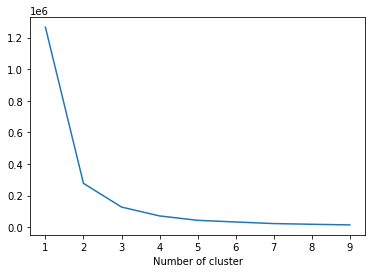

In [39]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [40]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [41]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,439.0,50.020501,7.377743,39.0,43.0,49.0,56.0,63.0
1,608.0,8.312500,4.404323,0.0,5.0,8.0,12.0,16.0
2,349.0,76.885387,8.373023,64.0,70.0,76.0,84.0,91.0
3,444.0,24.373874,4.959870,17.0,20.0,23.0,27.0,35.0


In [42]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [43]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [44]:

tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()

In [45]:
tx_frequency.columns = ['CustomerID','Frequency']

In [46]:
tx_frequency.head()

,CustomerID,Frequency
0,12747.0,35
1,12748.0,582
2,12749.0,54
3,12821.0,6
4,12823.0,1


In [47]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [48]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,14620.0,12,3,30
1,14740.0,4,3,89
2,17068.0,11,3,76
3,12971.0,4,3,73
4,15194.0,6,3,64


In [49]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

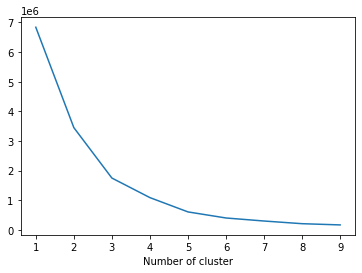

In [50]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [51]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [52]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1605.0,24.218069,17.761893,1.0,10.0,20.0,36.0,70.0
1,1.0,1364.000000,NaN,1364.0,1364.0,1364.0,1364.0,1364.0
2,11.0,496.000000,125.912668,331.0,422.5,452.0,570.0,730.0
3,223.0,116.560538,43.816927,71.0,83.5,104.0,131.5,285.0


In [53]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [54]:
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']

In [55]:
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()

In [56]:
tx_revenue.head()

,CustomerID,Revenue
0,12747.0,1082.09
1,12748.0,4336.73
2,12749.0,782.10
3,12821.0,92.72
4,12823.0,459.00


In [57]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [58]:
import warnings
warnings.filterwarnings("ignore")

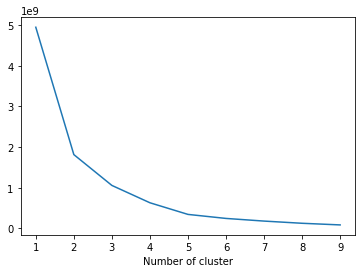

In [59]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [60]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [61]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [62]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1756.0,504.760245,444.567580,-1462.50,204.3075,349.590,666.8325,2131.72
1,72.0,3760.423486,1538.877714,2159.16,2685.1875,3141.610,4222.5050,7969.99
2,10.0,14092.686000,2855.109881,10348.13,11268.3675,15124.345,16124.8250,17700.64
3,2.0,30599.645000,6343.928696,26113.81,28356.7275,30599.645,32842.5625,35085.48


In [63]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,12,3,30,0,393.28,0
1,15194.0,6,3,64,0,1439.02,0
2,18044.0,5,3,57,0,808.96,0
3,18075.0,12,3,35,0,638.12,0
4,15241.0,0,3,64,0,947.55,0


In [64]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [65]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,77.014925,18.432836,295.824239
1,50.887828,24.522673,367.334177
2,26.590476,31.028571,500.973095
3,10.243902,36.652439,633.871402
4,8.109375,103.835938,1983.985086
5,6.482759,138.965517,4326.155172
6,7.357143,322.071429,12177.627143
7,3.000000,779.333333,11350.896667


In [66]:
tx_user.groupby('OverallScore')['Recency'].count()


OverallScore
0    335
1    419
2    420
3    492
4    128
5     29
6     14
7      3
Name: Recency, dtype: int64

In [67]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value'

In [68]:
tx_user.head()


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value


In [69]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom


In [70]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']

In [71]:
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']


In [72]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom,22.50
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom,16.95
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom,66.40
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom,32.70
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom,51.00


In [73]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')

In [74]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,NaN
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04


In [75]:
tx_merge = tx_merge.fillna(0)

In [76]:
tx_merge.groupby('Segment')['m6_Revenue'].mean()

Segment
High-Value    17968.362609
Low-Value       703.559983
Mid-Value      1718.212598
Name: m6_Revenue, dtype: float64

In [77]:
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [78]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

In [79]:
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

In [80]:

tx_merge.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1397.0,398.393172,422.252144,-609.40,0.0000,298.000,687.7200,1448.78
1,368.0,2501.323098,936.361335,1464.05,1739.9875,2165.315,3054.7925,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.4350,6986.545,9607.3225,16756.31


In [81]:
tx_cluster = tx_merge.copy()

In [82]:
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1397.0,398.393172,422.252144,-609.40,0.0000,298.000,687.7200,1448.78
1,368.0,2501.323098,936.361335,1464.05,1739.9875,2165.315,3054.7925,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.4350,6986.545,9607.3225,16756.31


In [83]:
tx_class = pd.get_dummies(tx_cluster)

In [84]:
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.846486
Revenue               0.600919
RevenueCluster        0.468524
OverallScore          0.374182
FrequencyCluster      0.364976
Frequency             0.359304
Segment_High-Value    0.353371
RecencyCluster        0.238332
Segment_Mid-Value     0.168752
CustomerID           -0.027701
Recency              -0.239131
Segment_Low-Value    -0.266561
Name: LTVCluster, dtype: float64

In [85]:
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']


In [89]:
from sklearn.model_selection import train_test_split

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)


In [91]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.90
Accuracy of XGB classifier on test set: 0.77


In [92]:
tx_class.groupby('LTVCluster').CustomerID.count()/tx_class.CustomerID.count()

LTVCluster
0    0.767161
1    0.202087
2    0.030752
Name: CustomerID, dtype: float64

In [93]:
y_pred = ltv_xgb_model.predict(X_test)

In [101]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        70
           1       0.36      0.22      0.28        18
           2       0.50      0.75      0.60         4

    accuracy                           0.77        92
   macro avg       0.57      0.63      0.59        92
weighted avg       0.74      0.77      0.75        92

